In [1]:
%matplotlib inline
%load_ext rpy2.ipython
from ml import query
import math
from pbto2 import data

In [320]:
d = data.get_raw_data()
d = d[['uid', 'tsi_min', 'tsa_min', 'datetime', 'age', 'sex', 'marshall', 'gcs', 'pbto2', 'pao2', 'gos-3', 'bo2']]

In [321]:
d = d[~d['gos-3'].isnull()]
d = d[~d['marshall'].isnull()]
d = d[~d['pbto2'].isnull()]
d = d[d['tsa_min'] < 4320]
#d = d[d['tsi_min'] <= 4320]
#d = d[d['tsi_min'] <= 1440]
#d = d[d['tsi_min'] <= 2880]
#d = d[d['pbto2'] > 0]
#d = d.iloc[np.random.permutation(np.arange(len(d)))[:5000],:]
d['gos-3-binary'] = d['gos-3'].apply(lambda x: 0 if x <= 3 else 1)
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13025 entries, 0 to 22314
Data columns (total 13 columns):
uid             13025 non-null int64
tsi_min         12840 non-null float64
tsa_min         13025 non-null int64
datetime        13025 non-null datetime64[ns]
age             13025 non-null int64
sex             13025 non-null float64
marshall        13025 non-null float64
gcs             13025 non-null float64
pbto2           13025 non-null float64
pao2            3946 non-null float64
gos-3           13025 non-null float64
bo2             13025 non-null float64
gos-3-binary    13025 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(4)
memory usage: 1.4 MB


# Examine 0 Pbto2 Values

In [322]:
uids = d[d['pbto2'] <= 0]['uid'].unique()
d_plt = d[d['uid'].isin(uids)]

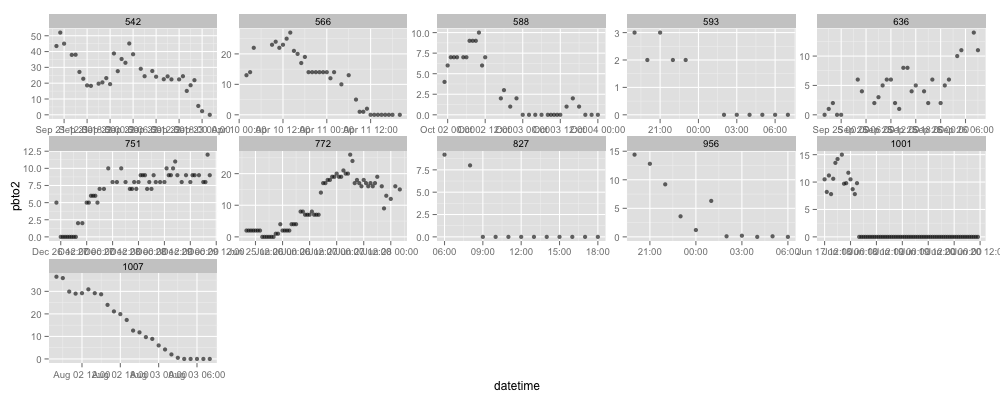

In [323]:
%%R -i d_plt -w 1000 -h 400 -u px
library(dplyr)
library(ggplot2)

d_plt %>% select(pbto2, uid, datetime) %>% 
    mutate(pbto2 = as.numeric(pbto2), uid=factor(as.integer(uid))) %>% 
    ggplot(aes(x=datetime, y=pbto2)) + geom_point(alpha=.6) + 
    facet_wrap(~uid, ncol=5, scales='free')

In [324]:
# Based on the above remove certain uids or measurements that seem unrealistic
def remove_after_first_zero(d, var, uids):
    d1 = d[~d['uid'].isin(uids)]
    d2 = d[d['uid'].isin(uids)]
    d2 = d2.groupby('uid', group_keys=False)\
        .apply(lambda x: x[x['datetime'] < x[x[var] <= 0]['datetime'].min()])
    return d1.append(d2)
        
rm_uids = [827]
d_clean = d[~d['uid'].isin(rm_uids)].copy()

rm_zero_uids = [751, 772]
d_clean = d_clean[(~d_clean['uid'].isin(rm_zero_uids)) | (d_clean['pbto2'] > 0)]

trim_uids = [566, 588, 593, 1001, 1007]
d_clean = remove_after_first_zero(d_clean, 'pbto2', trim_uids)

assert len(d['uid'].unique()) - len(rm_uids) == len(d_clean['uid'].unique())

d_plt = d_clean[d_clean['uid'].isin(uids)]

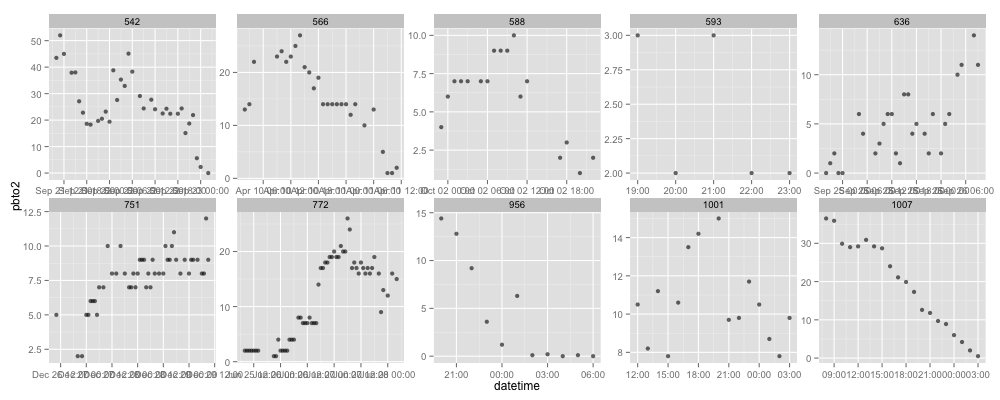

In [325]:
%%R -i d_plt -w 1000 -h 400 -u px
library(dplyr)
library(ggplot2)

d_plt %>% select(pbto2, uid, datetime) %>% 
    mutate(pbto2 = as.numeric(pbto2), uid=factor(as.integer(uid))) %>% 
    ggplot(aes(x=datetime, y=pbto2)) + geom_point(alpha=.6) + 
    facet_wrap(~uid, ncol=5, scales='free')

## Export Results

In [326]:
d.to_csv('/Users/eczech/data/ptbo2/export/data_long_cutpoint_72hr.csv', index=False)

## Other Analysis

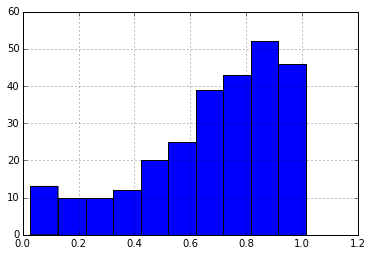

In [249]:
d.groupby('uid').apply(lambda x: len(x['pbto2'].dropna())/72).hist()

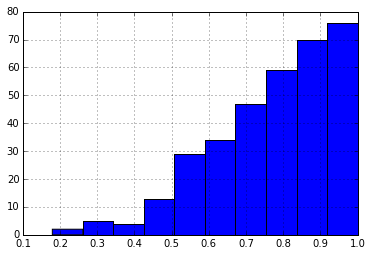

In [239]:
def get_fraction(x, var=None):
    x = x[[var, 'datetime']].dropna()
    if len(x) == 0:
        return None
    min_date = x['datetime'].min()
    max_date = x['datetime'].max()
    d = ((max_date - min_date).total_seconds() / 3600) + 1
    return pd.Series([d, len(x), len(x)/d], index=['hours', 'n', 'frac'])
fracs = d.groupby('uid').apply(get_fraction, var='pbto2')
fracs['frac'].hist()

Plots of bo2 vs pbto2:

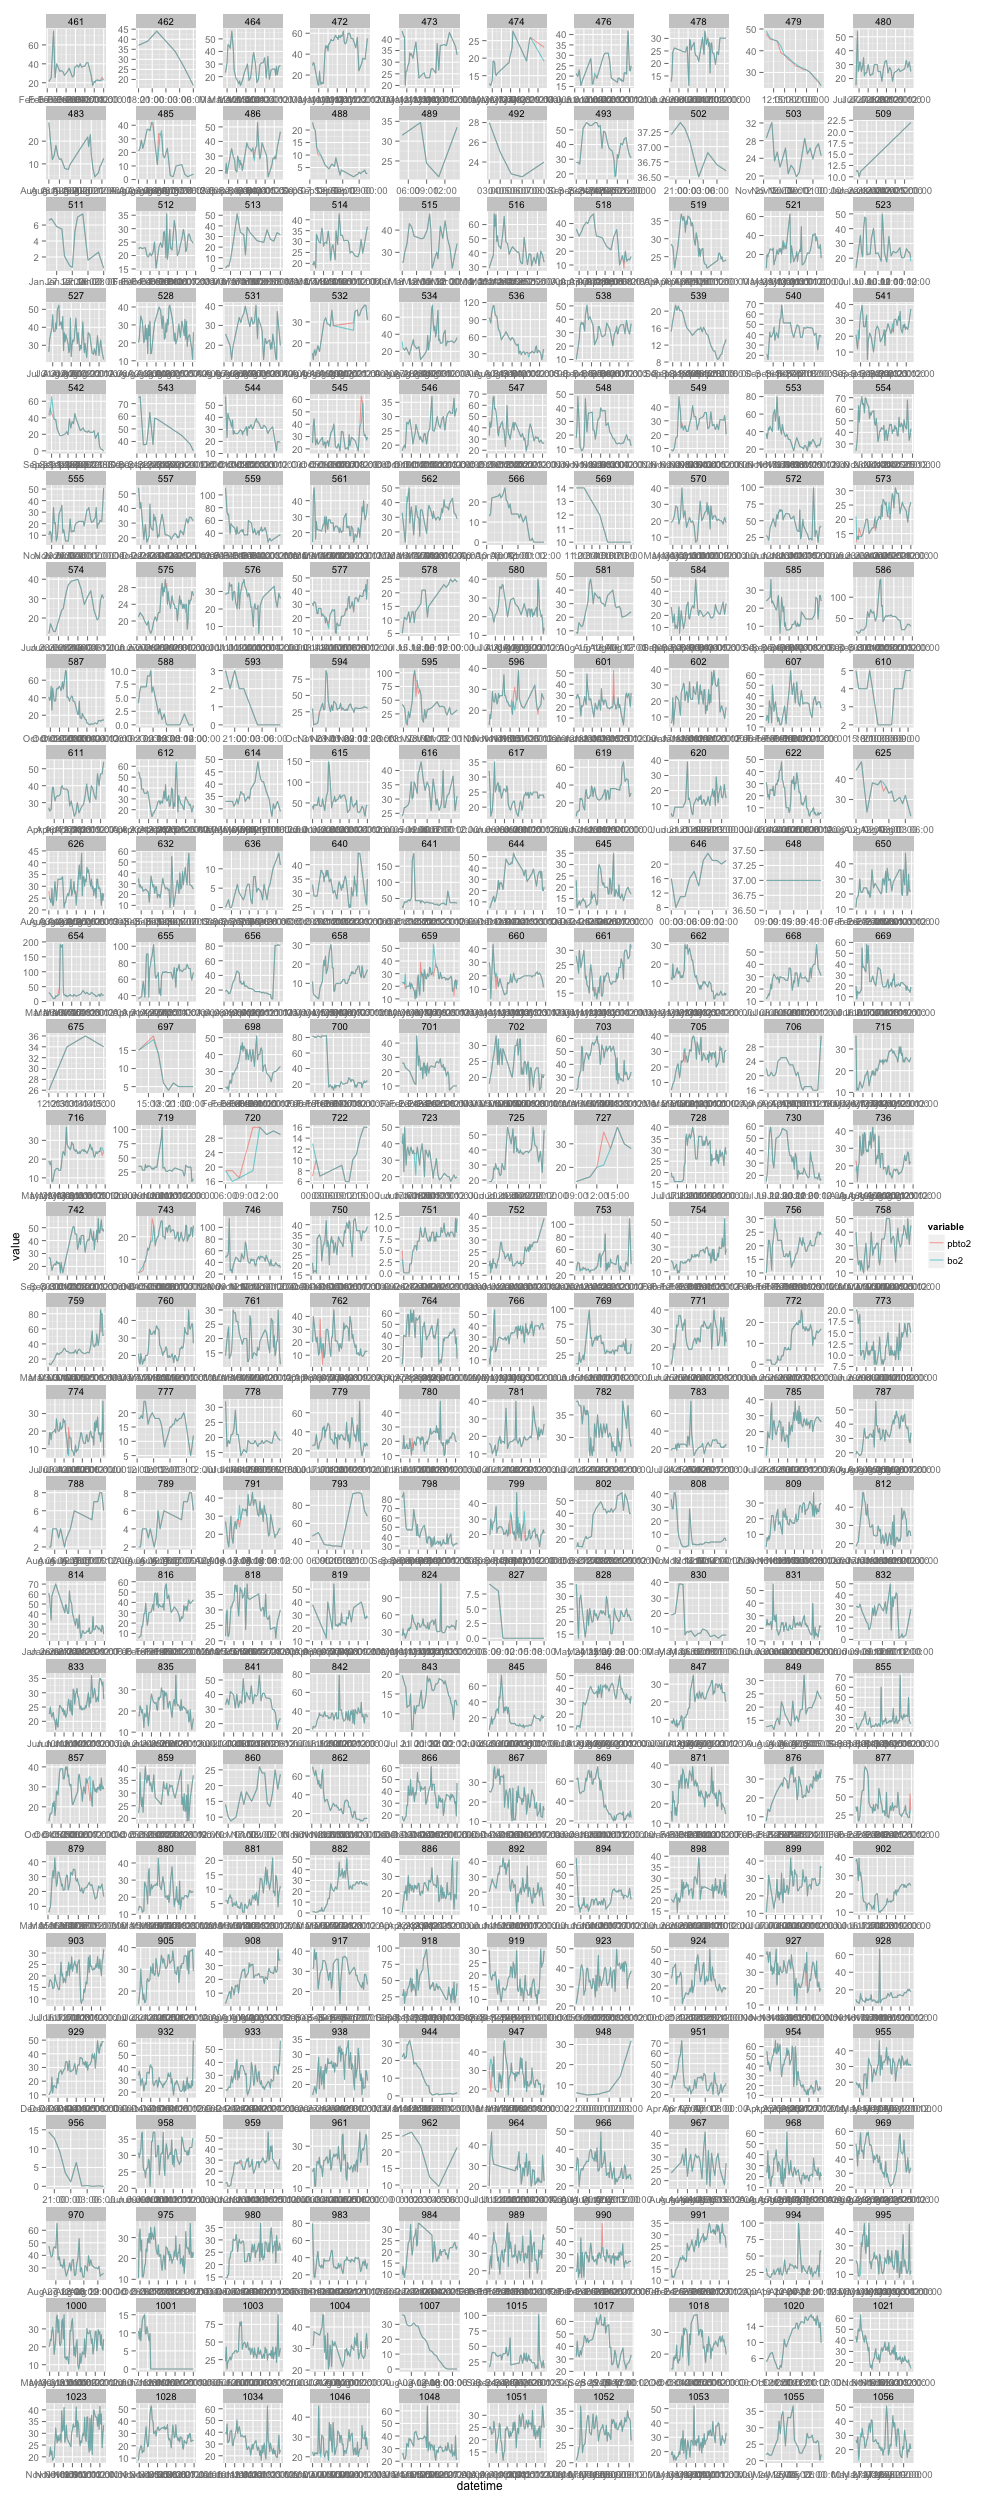

In [192]:
%%R -i d -w 1000 -h 2500 -u px
library(dplyr)
library(ggplot2)
library(reshape2)
d %>% select(pbto2, bo2, uid, datetime) %>% 
    mutate(pbto2 = as.numeric(pbto2), bo2=as.numeric(bo2), uid=factor(as.integer(uid))) %>% 
    melt(id.vars=c('uid', 'datetime')) %>%
    ggplot(aes(x=datetime, y=value, color=variable)) + geom_line(alpha=.6) + 
    facet_wrap(~uid, ncol=10, scales='free')


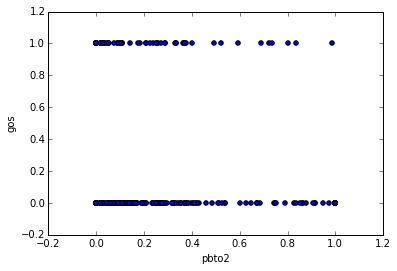

In [252]:
def get_pbto2(x):
    t = 20
    n_below = (x['pbto2'] < t).sum()
    return n_below / len(x)
    if n_below == 0:
        return t
    return x[x['pbto2'] < t]['pbto2'].sum() / n_below
dp = d.groupby('uid')\
    .apply(lambda x: pd.Series([get_pbto2(x), x['gos-3-binary'].iloc[0]], index=['pbto2', 'gos']))
dp.plot(kind='scatter', x='pbto2', y='gos')

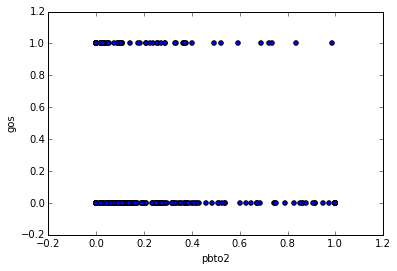

In [222]:
def get_pbto2(x):
    if len(x) < 10:
        return None
    t = 20
    n_below = (x['pbto2'] < t).sum()
    n_above = (x['pbto2'] >= t).sum()
    return n_below / len(x)
    if n_below == 0:
        return t
    return x[x['pbto2'] < t]['pbto2'].sum() / n_below
dp = d.groupby('uid')\
    .apply(lambda x: pd.Series([get_pbto2(x), x['gos-3-binary'].iloc[0]], index=['pbto2', 'gos']))
dp.plot(kind='scatter', x='pbto2', y='gos')